# Fashion MNIST classifier

This notebook is similar to `example_classifier` except that :
- The code is executed with the `JAX` backend
- The model architecture differs
- A custom `learning-rate scheduler` is passed to the optimizer
- The `Fashion MNIST` dataset is used instead of `MNIST`
- It trains the model multiple times : it does not *restart* training but *continues* it and tracks configuration for all independant runs !

## Imports + model initialization

In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

import numpy as np
import pandas as pd

from keras import tree

from models import MNISTClassifier, get_pretrained
from utils import set_display_options, plot, plot_multiple, plot_confusion_matrix
from utils.keras_utils import show_version, ops
from utils.datasets import get_dataset, prepare_dataset, test_dataset_time

set_display_options()

model_name = 'fashion_mnist_classifier'
show_version()

Keras version : 3.3.3 - backend (jax) : 0.4.28


In [3]:
config = {
    'labels'     : list(range(10)),
    'input_size' : (28, 28, 1),
    
    'bnorm'  : 'never',
    'drop_rate'   : 0.5,
    'dense_units' : 28,
    'dense_activation' : None,
    'dense_drop_rate'  : 0.
}
model = MNISTClassifier(name = model_name, ** config)

print(model)

Initializing model with kwargs : {'architecture': 'simple_cnn', 'input_shape': (28, 28, 1), 'output_shape': 10, 'n_conv': 2, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'pooling': 'max', 'dense_as_final': True, 'n_dense': 1, 'dense_size': 64, 'final_activation': 'softmax', 'final_name': 'classification_layer', 'name': 'cnn_classifier', 'bnorm': 'never', 'drop_rate': 0.5, 'dense_units': 28, 'dense_activation': None, 'dense_drop_rate': 0.0}
Set `use_mask = False` by default as the masking operation is not supported. To remove this message or change the behavior, explicitely pass `use_mask = ...`
Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Save `model` to pretrained_models/fashion_mnist_classifier/saving/ckpt-0000.keras
MNISTClassifier `fashion_mnist_class

## Model instanciation + dataset loading

The last cell shows how to visualize learning rate from custom learning rate schedulers

In [4]:
model = MNISTClassifier(name = model_name) # equivalent to get_pretrained(model_name)

# equivalent to
# lr = DivideByStep(maxval = 1e-2, minval = 1e-3, factor = 1.)

lr = {'name' : 'DivideByStep', 'minval' : 1e-3, 'maxval' : 1e-2, 'factor' : 1.}

model.compile(optimizer_config = {'lr' : lr}, optimizer = 'sgd')

print(model)
model.summary()

Model compiled successfully !
- Optimizer 	: {'name': 'SGD', 'learning_rate': {'module': 'custom_train_objects.optimizers.lr_schedulers', 'class_name': 'DivideByStep', 'config': {'minval': 9.999999747378752e-06, 'maxval': 0.009999999776482582, 'factor': 1.0}, 'registered_name': 'DivideByStep'}, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.0, 'nesterov': False}
- Loss 	: crossentropy
- Metric 	: accuracy


========== fashion_mnist_classifier ==========
Model instance `model`
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 12
- Number of parameters 	: 24740

- Optimizer 	: {'name': 'SGD', 'learning_rate': {'module': 'custom_train_objects.optimizers.lr_schedulers', 'class_name': 'DivideByStep', 'config': {'minval': 9.999999747378752e-06, 'maxval': 0.009999999776482582, 'fact

Model: "cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation               │ (None, 28, 28, 16)     │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_1             │ (None, 14, 14, 16)     │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │        21,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_layer (Dense)    │ (None, 10)             │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_2             │ (None, 10)             │             0 │
│ (CustomActivation)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,740 (96.64 KB)

 Trainable params: 24,740 (96.64 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
dataset_name = 'fashion_mnist' if 'fashion' in model_name else 'mnist'
ds = get_dataset(dataset_name)

if isinstance(ds, dict):
    train, valid = ds['train'], ds['test']
    print(train)
    print(valid)
else:
    train, valid = ds
    print('train : {} - valid : {}'.format(
        tree.map_structure(ops.shape, train), tree.map_structure(ops.shape, valid)
    ))


train : ((60000, 28, 28), (60000,)) - valid : ((10000, 28, 28), (10000,))


## Training + history analysis

Based on the below cells, it becomes possible to reproduce the model training by checking the different runs / parameters passed to the `fit` method at each round. In this case, 3 rounds have been performed of respectively 10, 15 and 25 epochs, with an early stopping for the 2 last rounds. The convergence criterion has not been reached, which is also visible in the metrics plots, where no convergence can be observed. This may indicated that the `SGD` optimizer is probably not the best one for this scenario, or that more training should be required ;)

The training took 7sec for 10 epochs (1st round) 5sec for 15 epochs (2nd round) and 9sec for 25 epochs (3rd round). This indicates that the 3 rounds have been executed sequentially without restarting the kernel, because the 1st round is always longer due to XLA-compilation.

In [ ]:
model.fit(
    train,
    validation_data = valid,
    epochs     = ...,
    batch_size = ...,
    
    additional_infos = {'dataset' : dataset_name},

    add_early_stopping = ...
)

===== History =====
    accuracy      loss  val_accuracy  val_loss
0   0.131967  2.293011        0.1840  2.292314
1   0.162583  2.281176        0.1703  2.285858
2   0.175750  2.271803        0.1747  2.279865
3   0.185067  2.263358        0.1833  2.274120
4   0.189700  2.256872        0.2100  2.268800
..       ...       ...           ...       ...
45  0.310667  2.169927        0.3898  2.175428
46  0.314517  2.168476        0.3930  2.174013
47  0.314433  2.167945        0.3969  2.172622
48  0.317183  2.166365        0.4005  2.171233
49  0.317483  2.166347        0.4047  2.169837

[50 rows x 4 columns]


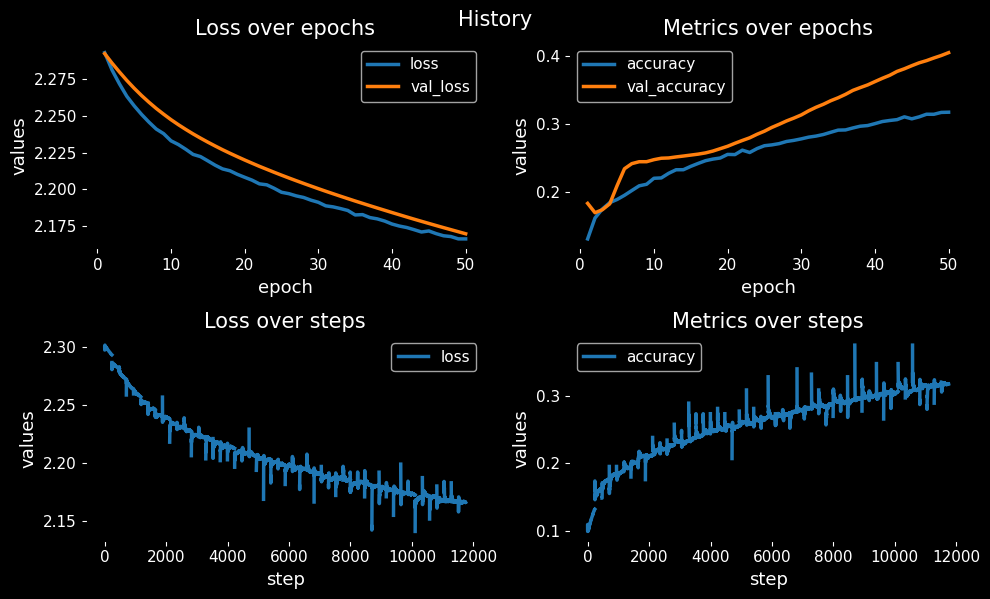

In [23]:
print(model.history)
model.plot_history()

In [24]:
print("Training config :")
print(pd.DataFrame(model.training_logs))
print("\nTraining parameters :")
print(pd.DataFrame(model.training_config))
print("\nTraining informations :")
print(pd.DataFrame(model.training_infos))


Training config :
          start           end      time  interrupted  start_epoch  final_epoch
0  1.717169e+09  1.717169e+09  7.416934        False            0           10
1  1.717169e+09  1.717169e+09  5.570650        False           10           25
2  1.717169e+09  1.717169e+09  8.919292        False           25           50

Training parameters :
   batch_size  augment_prct  epochs  initial_epoch add_early_stopping
0         256          0.25      10              0                NaN
1         256          0.25      25             10               True
2         256          0.25      50             25               True

Training informations :
          start           end      time  interrupted  start_epoch  final_epoch                     dataset  \
0  1.717169e+09  1.717169e+09  7.416934        False            0           10  {'train': {}, 'valid': {}}   
1  1.717169e+09  1.717169e+09  5.570650        False           10           25  {'train': {}, 'valid': {}}   
2  1.717

## Prediction

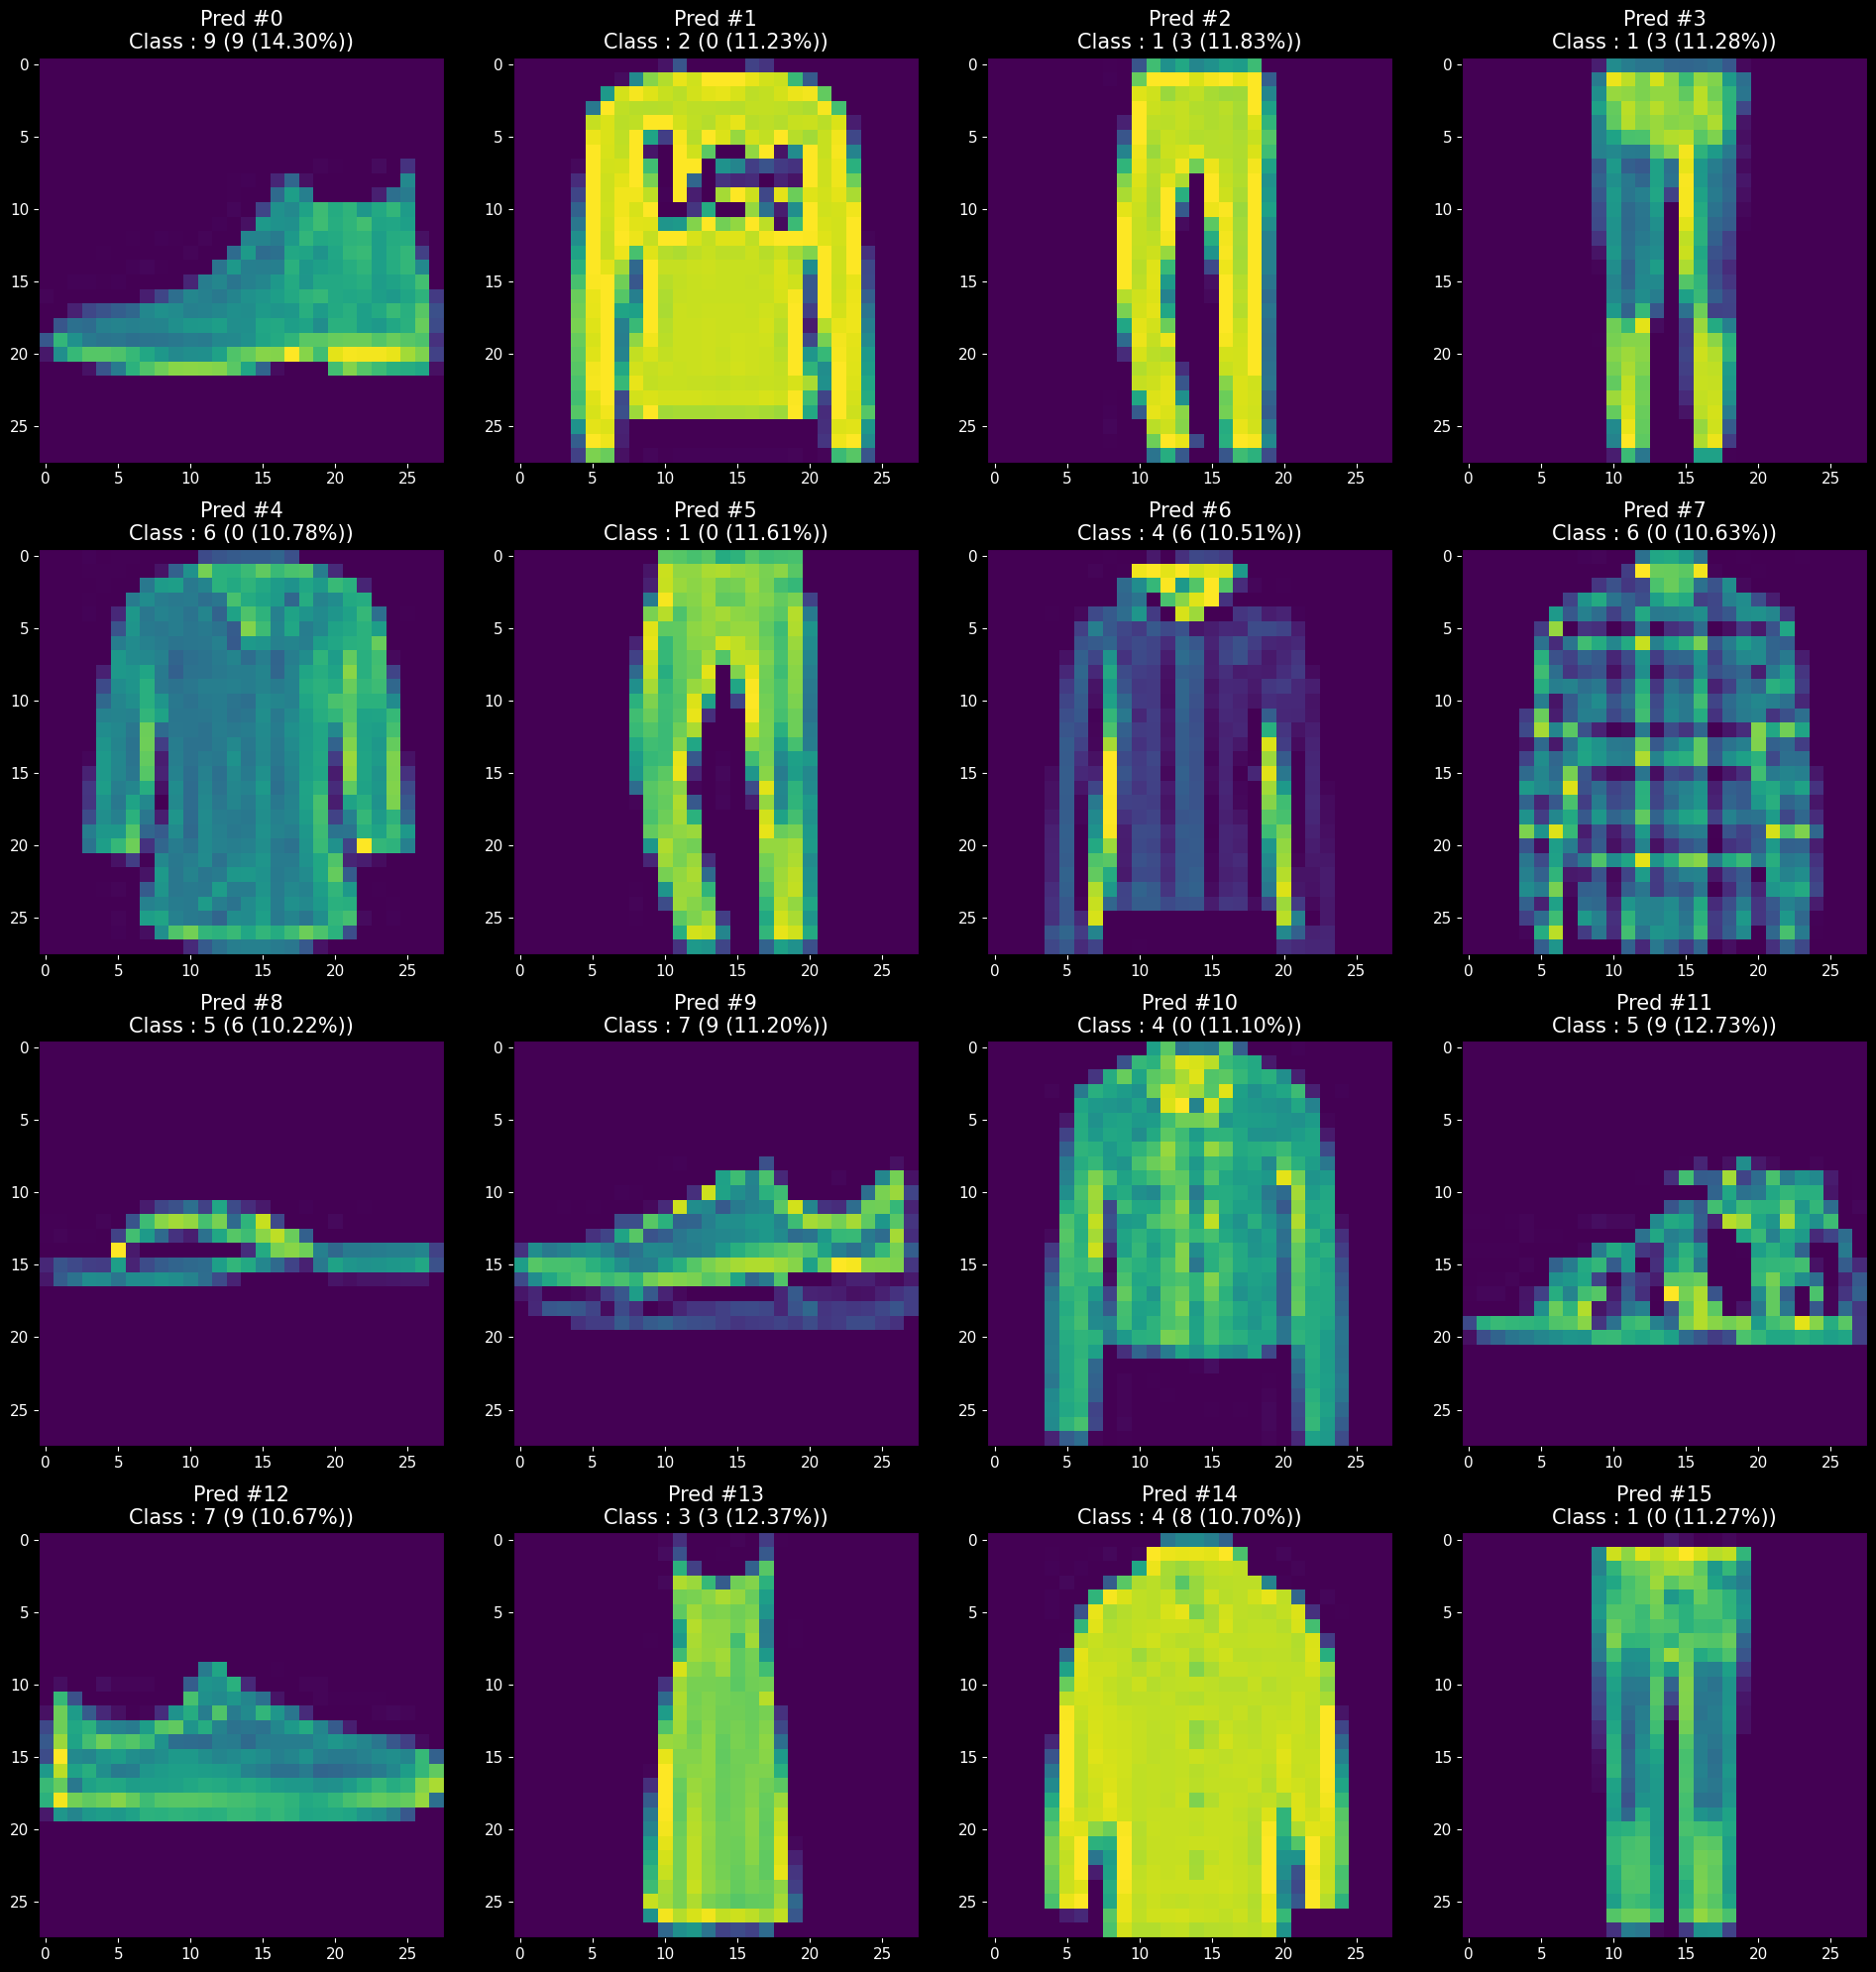

In [25]:
predictions = {}
for i, data in enumerate(zip(* valid)):
    if i >= 16: break
    image, label = model.prepare_data(* data)
    
    pred, score, probs = model.predict([image])[0]
    predictions['Pred #{}\nClass : {} ({} ({:.2f}%))'.format(i, label, pred, score * 100)] = image

plot_multiple(** predictions, ncols = 4, plot_type = 'imshow')

## Confusion matrix

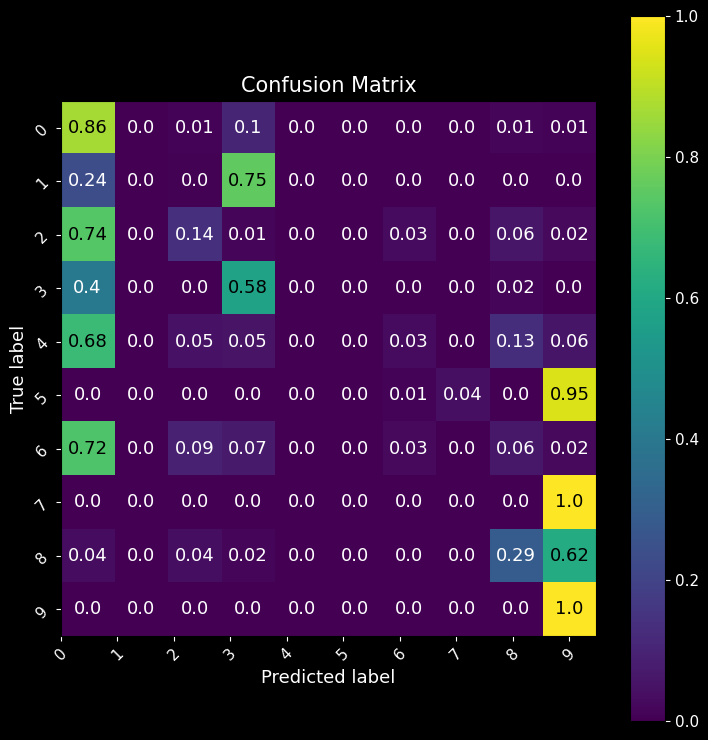

In [26]:
images, labels = [], []
for i, data in enumerate(zip(* valid)):
    image, label = data #model.prepare_data(* data)
    images.append(image)
    labels.append(label)

pred = model.predict(images)
pred = [p[0] for p in pred] # p[1] is the confidence score

plot_confusion_matrix(true = labels, pred = pred, norm = True)

## Test processing pipeline

When it is the first time you train a model, it is recommanded to assess the correctness of the processing pipeline. The below cells illustrate how to check the data statistics (values within a batch), as well as a visual analysis of the processing result. 

- The `get_dataset_config` returns the processing functions defined by the model that have to be forwarded to the `prepare_dataset` method
- The `prepare_dataset` instanciates a `tf.data.Dataset` instance based on the given data (also supports `pd.DataFrame` as well as other dataset formats)

This analysis demonstrates the correct alignment between images and labels, as well as correct value ranges for the image pixels (i.e., between 0 and 1)

In [15]:
from loggers import set_level

set_level('debug', 'utils.datasets') # the 2nd argument tells to only set the `datasets.*` module to debug

config = model.get_dataset_config('train', batch_size = 64)

ds_train = prepare_dataset(train, ** config)
test_dataset_time(ds_train, steps = 1000)

Original dataset : <_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
- Dataset after preparation : <_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset is cached
- Dataset is shuffled
- Dataset after batch : <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
- Dataset is prefetched


 94%|█████████████████████████████████████████████████████████████████████████▏    | 938/1000 [00:00<00:00, 2065.74it/s]


938 batches generated in 453 ms (2067.828 batch / sec)
- Initial batch time : 385 ms
- Average batch time : 483 μs
- Batch statistics   : [
    "shape : (32, 28, 28, 1) - min : 0.000 - max : 1.000 - mean : 0.272",
    "shape : (32,) - min : 0 - max : 9"
]



{'steps': 938,
 'batch_size': 64,
 'total time': 0.4536161422729492,
 'initial batch time': 0.3855564594268799,
 'average batch time': 0.00048359929879845335}

### Test learning-rate scheduler

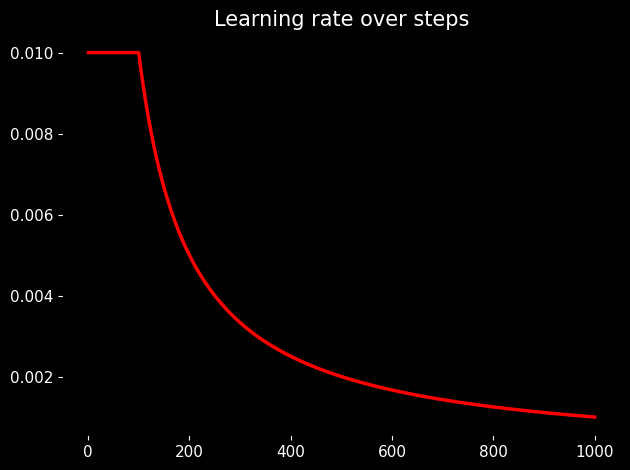

In [21]:
from custom_train_objects.optimizers import get_lr_scheduler

lr_config= {'scheduler' : 'DivideByStep', 'minval' : 1e-3, 'maxval' : 1e-2, 'factor' : 1.}

lr_scheduler = get_lr_scheduler(** lr_config)
lr_scheduler.plot(1000)